In [1]:
import pandas as pd
from fastai.text import *

In [2]:
pitt_path = Path('../data/Pitt')
model_path = pitt_path.parent/'models'

In [3]:
pitt_df = pd.read_csv(model_path/'pitt-cookie.csv')
pitt_df.head()

,Unnamed: 0,group,is_validation,sentence,tagged,text
0,0,control,False,"['the', 'scene', 'is', 'in', 'the', 'kitchen',...","[('the', 'DET:ART', 'the', (1, 2, 'DET')), ('s...",the scene is in the kitchen .
1,1,control,False,"['the', 'mother', 'is', 'wiping', 'dishes', 'a...","[('the', 'DET:ART', 'the', (1, 2, 'DET')), ('m...",the mother is wiping dishes and the water is r...
2,2,control,False,"['a', 'boy', 'is', 'trying', 'to', 'get', 'coo...","[('a', 'DET:ART', 'a', (1, 2, 'DET')), ('boy',...",a boy is trying to get cookies out of a jar an...
3,3,control,False,"['the', 'little', 'girl', 'is', 'reacting', 't...","[('the', 'DET:ART', 'the', (1, 3, 'DET')), ('l...",the little girl is reacting to his falling .
4,4,control,False,"['it', 'seems', 'to', 'be', 'summer', 'out', '.']","[('it', 'PRO:PER', 'it', (1, 2, 'SUBJ')), ('se...",it seems to be summer out .


## fastai API

In [4]:
bs = 128

To create the Language Model, we use all texts and keep 10% for validation.

In [5]:
data_lm = (TextList.from_df(pitt_df, path=model_path, cols='text')
                .split_by_rand_pct(0.1)
                .label_for_lm()
                .databunch(bs=bs)
       )

In [6]:
data_lm.show_batch()

idx,text
0,xxbos the curtains are blowing . xxbos it must be a xxunk breeze . xxbos there 's grass outside in the garden . xxbos mother 's finished xxunk of the dishes . xxbos kitchen 's very xxunk . xxbos the mother seems to have nothing in the house to eat except cookies in the cookie jar . xxbos the children look to be almost about the same xxunk . xxbos
1,because his head 's gon na hit the kitchen cupboards . xxbos it looks like the house is set in the xxunk . xxbos and it 's a xxunk house either that or you 're seeing another house or a wing of the house . xxbos there 's grass growing a little path . xxbos mother looks pretty xxunk back there . xxbos wait xxunk i put my glasses on
2,"xxbos and the mother is gon na get xxunk when he xxunk and the cookie jar comes down . xxbos and i think that 's about all . xxbos somebody 's getting cookies out_of the cookie jar , standing on a stool . xxbos and the girl 's saying "" / . xxbos shh do n't let somebody hear . xxbos and the mother 's drying dishes . xxbos the"
3,girl is shushing whatever you call that the boy because evidently they 're stealing them . xxbos sneaking them is a better xxunk . xxbos and you said happening . xxbos a xxunk . xxbos it hasta be movement . xxbos and xxunk xxunk things ? xxbos the lady is standing in a puddle of water . xxbos and the window is open . xxbos and there 's a house
4,had a trunk it would xxunk . xxbos this is the top xxunk of the window and it hasta have a trunk down here and that 's just grass . xxbos so what / ? xxbos well what 's this ? xxbos is n't that a tree ? xxbos looks like a tree to me . xxbos okay what do you want me to / / ? xxbos all the


In [7]:
torch.cuda.empty_cache()

In [8]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


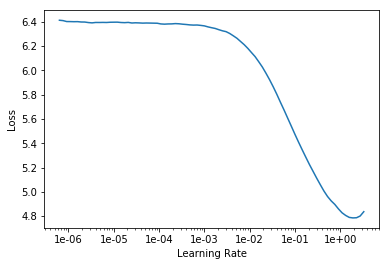

In [10]:
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(1, 3e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.610885,3.260271,0.381808,00:01


In [12]:
learn.save('cookie_fit_head')

In [13]:
learn.unfreeze()

In [14]:
learn.fit_one_cycle(10, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.978345,2.640269,0.436942,00:01
1,2.740958,2.550697,0.440737,00:01
2,2.590176,2.461462,0.449554,00:01
3,2.417425,2.428595,0.465402,00:01
4,2.248749,2.503143,0.473214,00:01
5,2.083412,2.525171,0.468750,00:01
6,1.923824,2.623457,0.469866,00:01
7,1.778338,2.652153,0.475670,00:01
8,1.643888,2.698079,0.471652,00:01
9,1.530110,2.705094,0.471317,00:01


We might be overfitting.

In [15]:
learn.save('cookie_fine_tuned')

In [16]:
learn.save_encoder('cookie_fine_tuned_enc')

## Classification

In [17]:
data_clas = (TextList.from_df(pitt_df, path=model_path, cols='text', vocab=data_lm.vocab)
                .split_by_rand_pct(valid_pct=0.2)
                .label_from_df(cols='group')
                .databunch(bs=bs)
              )

In [18]:
data_clas.show_batch()

text,target
xxbos it looks like she 's sort of laughing at the boy or putting her finger up to her mouth to be quiet so her mother does n't hear who is in the kitchen drying dishes but the water in the sink is overflowing onto the floor and she 's stepping in the water .,control
xxbos she has some of them dried already on the side as she 's looking out the window while the little boy is falling off the stool because he 's getting into the cookie jar to give to his little sister who 's reaching up to get the cookie also .,control
xxbos and the boy has one hand in the cookie jar and one with a cookie in it handing to the little girl who 's got her hand up for it and she looks like got her finger to mouth tell him to be careful .,control
xxbos the child is on a stool falling off as he 's reaching for the cookie jar with his right hand and trying to hand the other cookies to a little girl who 's reaching up with her left hand to get the cookie .,control
"xxbos he 's xxunk going to hand one cookie , it looks as though he is , to his sister and grab another one for himself but i xxunk that he 's gon na get all that done before the stool falls over .",control


In [19]:
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_clas.load_encoder('cookie_fine_tuned_enc')

In [20]:
learn_clas.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.63E-03


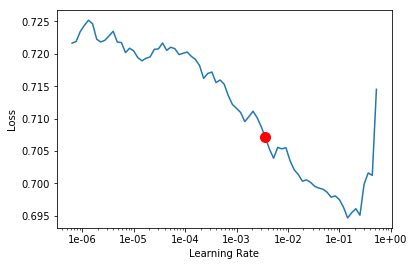

In [21]:
learn_clas.recorder.plot(skip_end=10, suggestion=True)

In [22]:
lr_clas = 1e-2  #2e-2?

In [23]:
learn_clas.fit_one_cycle(5, lr_clas, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.675566,0.646994,0.626241,00:01
1,0.662263,0.629796,0.638298,00:01
2,0.650239,0.646480,0.621986,00:01
3,0.634724,0.624312,0.647518,00:01
4,0.623004,0.621624,0.656738,00:01


In [24]:
learn_clas.save('cookie_first')

### Freeze the stem and keep tuning

In [25]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(3, slice(lr_clas/(2.6**4),lr_clas), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.628044,0.627164,0.643972,00:01
1,0.615350,0.605623,0.677305,00:01
2,0.582388,0.607186,0.662411,00:01


In [26]:
#learn_clas.save('second')

In [27]:
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(3, slice(lr_clas*0.1/(2.6**4), lr_clas*0.1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.554257,0.607653,0.663121,00:02
1,0.552135,0.608490,0.661702,00:02
2,0.541148,0.610138,0.669504,00:02


In [28]:
learn_clas.save('cookie_third')

### Unfreeze and fit a bit more

In [29]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(10, slice((lr_clas/20)/(2.6**4), lr_clas/20), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.529569,0.614082,0.664539,00:02
1,0.536716,0.608093,0.670922,00:02
2,0.537543,0.610625,0.673050,00:02
3,0.538222,0.612132,0.668085,00:02
4,0.530670,0.614379,0.675887,00:02
5,0.526609,0.611577,0.668794,00:02
6,0.531678,0.613483,0.669504,00:02
7,0.521502,0.611507,0.673050,00:02
8,0.518138,0.614706,0.667376,00:02
9,0.521326,0.615090,0.672340,00:02


In [30]:
learn.save('cookie_fourth')